# Predicting interest rates from Federal Reserve documents
## Per-sentence sentiment (Vol. 7)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

In [67]:
import os
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [68]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
#if IN_COLAB:
#  # Uninstall existing versions:
#  !pip uninstall bs4 -y
#  !pip uninstall textract -y
#  !pip uninstall numpy -y
#  !pip uninstall pandas -y
#  !pip uninstall requests -y
#  !pip uninstall tqdm -y
#  !pip uninstall nltk -y
#  !pip uninstall quandl -y
#  !pip uninstall scikit-plot -y
#  !pip uninstall seaborn -y
#  !pip uninstall sklearn -y
#  !pip uninstall torch -y
#  !pip uninstall transformers -y
#  !pip uninstall wordcloud -y
#  !pip uninstall xgboost -y
#  
#  # Install packages:
#  !pip install bs4==0.0.1
#  !pip install textract==1.6.3
#  !pip install numpy==1.19.4
#  !pip install pandas==1.1.4
#  !pip install requests==2.24.0
#  !pip install tqdm==4.51.0
#  !pip install nltk==3.5
#  !pip install quandl==3.5.3
#  !pip install scikit-plot==0.3.7
#  !pip install seaborn==0.11.0
#  !pip install sklearn==0.0
#  !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#  !pip install transformers==3.5.0
#  !pip install wordcloud==1.8.0
#  !pip install xgboost==1.2.1
#  os.kill(os.getpid(), 9)
#

In [70]:
# Python libraries
import pprint
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter
import xgboost as xgb
pprint.pprint(sys.path)

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
## Use TPU Runtime:
#if IN_COLAB:
#  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'  
#  VERSION = "20200220"
#  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#  !python pytorch-xla-env-setup.py --version $VERSION

In [72]:
## Use GPU Runtime:
if IN_COLAB:
  torch.cuda.get_device_name(0)
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, and then re-execute this cell.')
    os.kill(os.getpid(), 9)
  else:
    print(gpu_info)


Sun Jan 24 23:00:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    41W / 300W |   2277MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [73]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [74]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [75]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load and process input data

In [ ]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [ ]:
# Load previously processed non-text data
# Load data
#file = open(train_dir + 'nontext_train_small.csv', 'rb')
#meta_df = pickle.load(file)
#file.close()
meta_df = pd.read_csv (train_dir + 'nontext_train_small.csv')
print(meta_df.shape)
meta_df


(398, 11)


,date,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
0,1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1,1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
2,1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
3,1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
4,1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
...,...,...,...,...,...,...,...,...,...,...,...
393,2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279
394,2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
395,2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
396,2020-03-31,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.114279,13.910886,0.006092


In [ ]:
# List of Non-text columns
meta_columns = meta_df.drop(columns=['target']).columns.tolist()
meta_columns


['date',
 'prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [ ]:
# Load text data (pickle)
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

text_no_split = pd.read_csv(preprocessed_dir + 'text_no_split.csv')

# Load text data (comma-delimmited)
file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

text_split_200 = pd.read_csv(preprocessed_dir + 'text_split_200.csv')


,Unnamed: 0,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1.0,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1.0,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1.0,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1.0,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1.0,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


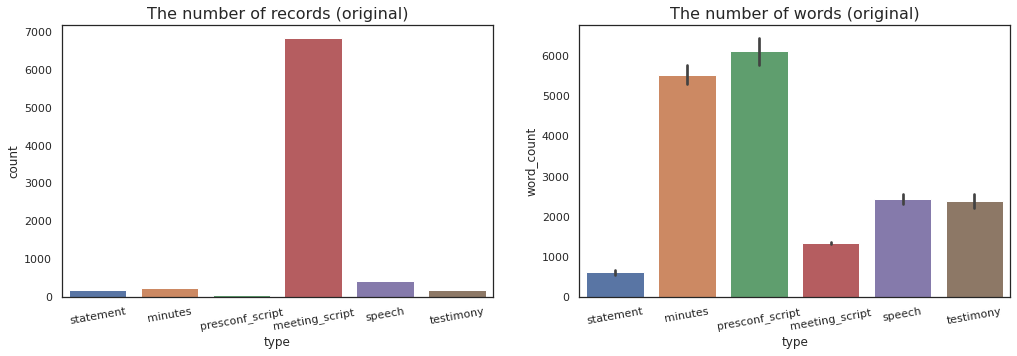

In [ ]:
# Check the number of records per document type
def plot_num_rec_word(df):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)
    
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.5,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


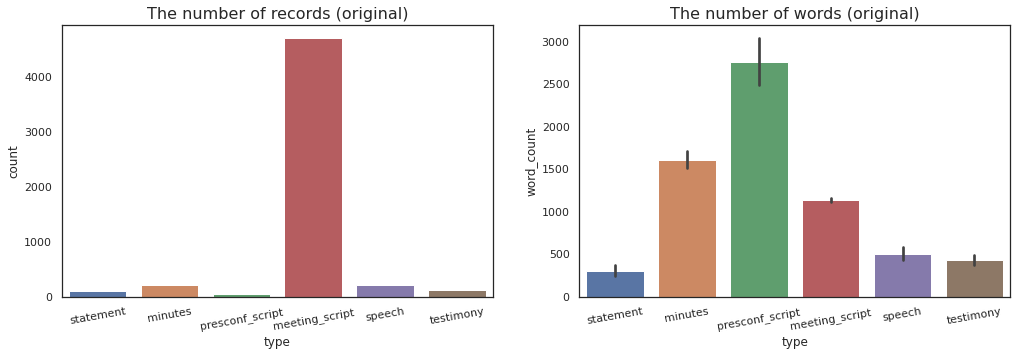

In [ ]:
plot_num_rec_word(text_keyword)
text_keyword.head()

In [ ]:
# # Drop meeting script data
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe

(1071, 12)



(1071, 12)


,Unnamed: 0,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1.0,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1.0,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1.0,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1.0,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1.0,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


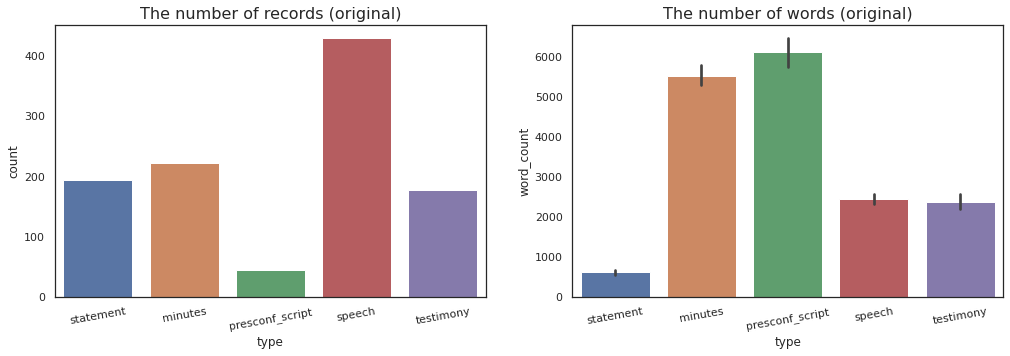

In [ ]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row     
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

In [ ]:
# Check balance of Rate Decision
#g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
#g.map(sns.countplot, 'next_decision')
#plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


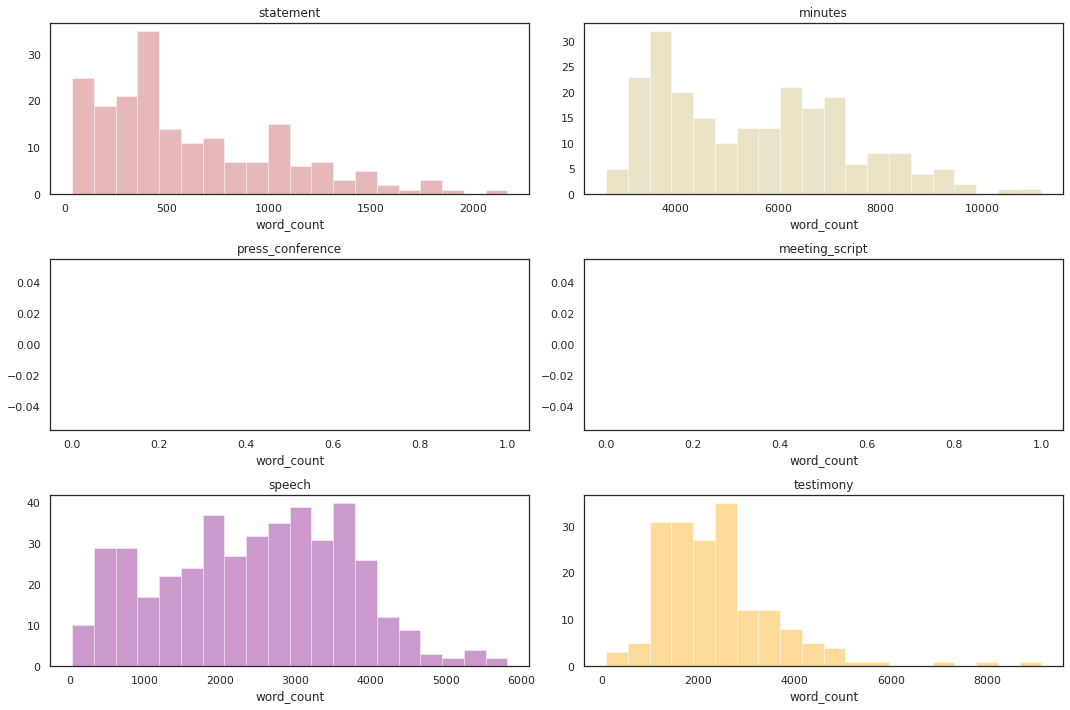

,Unnamed: 0,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
7903,7903,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,NaN,NaN,2020-06-10,0,0.0,I would like to begin by acknowledging the tra...
7904,7904,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1433,NaN,NaN,2020-07-29,0,0.0,Our country continues to face a difficult and ...
7905,7905,testimony,2020-06-30,Coronavirus and CARES Act,Jerome Powell,2759,NaN,NaN,2020-07-29,0,0.0,We meet as the pandemic continues to cause tre...
7906,7906,testimony,2020-09-22,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,2400,NaN,NaN,2020-11-05,0,NaN,"Chairwoman Waters, Ranking Member McHenry, and..."
7907,7907,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,2379,NaN,NaN,2020-12-16,0,NaN,"The Federal Reserve, along with others across ..."


In [ ]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'press_conference'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


In [ ]:
# Add a key for aggregation
train_df['key'] = train_df.index.get_level_values(0)
train_df['decision']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
7903    NaN
7904    NaN
7905    NaN
7906    NaN
7907    NaN
Name: decision, Length: 1071, dtype: float64

## Split each text by sentence

In [ ]:
# Split the data by sentence
def split_df(df, text_column='text'):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('float')
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('float')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

train_df = train_df.replace(np.nan, '0', regex=True)
train_sent_df = split_df(train_df)
print(train_sent_df.shape)


(110919, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


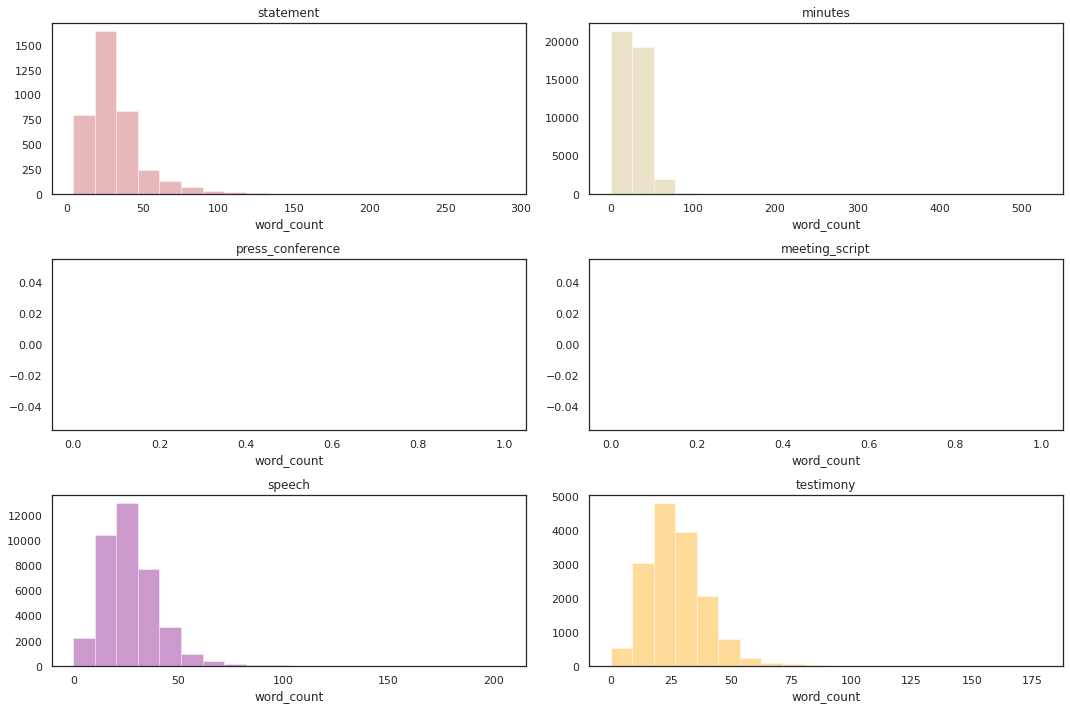

,Unnamed: 0,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,key
110914,7907,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,28,0,0,2020-12-16,0,0,The Federal Reserve lends an amount equal to t...,7907
110915,7907,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,21,0,0,2020-12-16,0,0,"With funding from the CARES Act, Department of...",7907
110916,7907,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,35,0,0,2020-12-16,0,0,The announcement and presence of the TALF has ...,7907
110917,7907,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,18,0,0,2020-12-16,0,0,The TALF interest rates are attractive to borr...,7907
110918,7907,testimony,2020-12-01,"Coronavirus Aid, Relief, and Economic Security...",Jerome Powell,25,0,0,2020-12-16,0,0,While the facility is authorized to extend up ...,7907


In [ ]:
# Check distribution
plot_distribution(train_sent_df, False)
train_sent_df.tail()

## Load the trained model

In [78]:
# Set Model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(output_dir + 'finphrase_bert_trained.dict'))
model.train()
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

UnpicklingError: ignored

## Stream the text input

In [79]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [80]:
def predict(text, model):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        pred : Prediction vector
    """        
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = F.softmax(outputs, dim=1).cpu().numpy()
    
    return pred

In [81]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model)

array([[0.55774283, 0.44225723]], dtype=float32)

In [82]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts
    
    return df

## Predict

### Bugs


```
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead
```



### Prediction Pipeline

In [83]:
doc_types = train_sent_df['type'].unique().tolist()
doc_types

['statement', 'minutes', 'presconf_script', 'speech', 'testimony']

In [ ]:
result_df = pd.DataFrame([], columns=train_df.columns)
for doc_type in doc_types:
    print('Processing {}...'.format(doc_type))
    train_sample = train_sent_df.loc[(train_sent_df['type']==doc_type)]
    res = score_text(train_sample, 'text', model)
    result_df = pd.concat([result_df, res], axis=0)
    
result_df.head()

Processing statement...



Processing minutes...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':



Processing presconf_script...



Processing speech...


In [ ]:
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)
result_df.head()


In [ ]:
result_df


In [ ]:
train_result = train_df.copy()
train_result['key2'] = train_result['type'] + "_" + train_result['key'].map(str)
result_df['key2'] = result_df['type'] + "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])
train_result.sort_values(['type', 'next_meeting'], inplace=True)

print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()


In [ ]:
def get_doctype_df(df, doc_type):
    if doc_type == 'all':
        new_df = df
    else:
        new_df = df.loc[df['type']==doc_type]
    new_df = new_df.groupby(by=['next_meeting', 'next_decision', 'next_rate'])['Negative', 'Neutral', 'Positive', 'sentiment'].sum()
    new_df.reset_index(level=[1,2], inplace=True)
    new_df.sort_index(inplace=True)
    new_df['next_rate_change'] = new_df['next_rate'] - new_df['next_rate'].shift(1)
    new_df['sentiment_pct'] = new_df['sentiment'] / (new_df['Positive'] + new_df['Negative'])
    new_df['sentiment_chg'] = new_df['sentiment'] - new_df['sentiment'].shift(1)
    return new_df
    

In [ ]:
stmt_df = get_doctype_df(train_result, 'statement')
minutes_df = get_doctype_df(train_result, 'minutes')
speech_df = get_doctype_df(train_result, 'speech')
testimony_df = get_doctype_df(train_result, 'testimony')
all_df = get_doctype_df(pd.concat([stmt_df, minutes_df, speech_df, testimony_df], axis=0), 'all')
all_df


In [ ]:
# Show corelations to target
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

def plot_sentiment(df, doc_type, sent_column):
    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
    sns.lineplot(y=df[sent_column], x=df.index.get_level_values(0), ax=ax1)
    ax1.set_xlim('1992-01-01', '2020-06-01')
    ax1.set_ylabel('Sentiment: {}'.format(sent_column))
    ax1.set_xlabel('Year')
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] > 0, facecolor='blue', alpha=0.2)
    ax1.fill_between(df.index.get_level_values(0), 0, df[sent_column], where=df[sent_column] < 0, facecolor='red', alpha=0.2)
    ax12 = ax1.twinx()
    sns.lineplot(y=df['next_rate'].fillna(0), x=df.index.get_level_values(0), ax=ax12, color='green')
    #ax12.yaxis.grid(True, which='major')
    ax12.set_ylim(-4,8)
    ax12.legend("Rate", loc='upper right')
    align_yaxis(ax1, 0, ax12, 0)
    arrow_style = dict(facecolor='black', shrink=0.05)
    ax12.annotate('QE1', xy=('2008-11-25', -2.5), xytext=('2008-11-25', -3.5), size=12, ha='right', arrowprops=arrow_style)
    ax12.annotate('QE1+', xy=('2009-03-18', -2), xytext=('2009-03-18', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -1), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE2+', xy=('2011-09-21', -2), xytext=('2011-09-21', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('QE3', xy=('2012-09-13', -2), xytext=('2012-09-13', -3), size=12, ha='center', arrowprops=arrow_style)
    ax12.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -2), size=12, ha='center', arrowprops=arrow_style)

    plt.title('Net sentiment over years with the next FED target rate', fontsize=16)

    corr_columns = ['sentiment', 'sentiment_pct', 'sentiment_chg', 'next_decision', 'next_rate_change', 'next_rate']
    sns.heatmap(df[corr_columns].astype(float).corr().iloc[:3], annot=True, fmt=".2f", ax=ax2, cmap= 'coolwarm', center=0, vmin=-1, vmax=1)
    ax2.set_title("Correlation", fontsize=16)
    
    plt.suptitle("Doc Type: {}".format(doc_type), fontsize=16)
    plt.show()
    plt.savefig("sentiment_plot_{}_{}_{}".format(df,doc_type, sent_column))#bbox_inches='tight')


In [ ]:
# Sentiment Plots
plot_sentiment(all_df, 'All', 'sentiment')
plot_sentiment(stmt_df, 'Statement', 'sentiment')
plot_sentiment(minutes_df, 'Minutes', 'sentiment')
plot_sentiment(presconf_df, 'Press Conference Script', 'sentiment')
plot_sentiment(m_script_df, 'Meeting Script', 'sentiment')
plot_sentiment(speech_df, 'Speech', 'sentiment')
plot_sentiment(testimony_df, 'Testimony', 'sentiment')


## Save Data

In [ ]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=train_dir, index_csv=True):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle', 'wb'))
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

else:
  def save_data(df, file_name, dir_name=train_dir):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle', 'wb'))
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))


In [ ]:
# Save text data
save_data(result_df, 'fomc_sent_result_df')

# Save BERT data
save_data(all_df, 'fomc_sentiment_bert_all')
save_data(stmt_df, 'fomc_sentiment_bert_stmt')
save_data(minutes_df, 'fomc_sentiment_bert_stmt')
save_data(presconf_df, 'fomc_sentiment_bert_stmt')
save_data(m_script_df, 'fomc_sentiment_bert_stmt')
save_data(speech_df, 'fomc_sentiment_bert_stmt')
save_data(testimony_df, 'fomc_sentiment_bert_stmt')

## Model and Train

In [ ]:
# Load data
file = open(train_dir + 'train_df.pickle', 'rb')
train_df = pickle.load(file)
file.close()
print(train_df.shape)

In [ ]:
train_df.drop(columns=['statement', 'minutes', 'press_conference', 'speech', 'testimony', 'text',
                      'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
                       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
                       'tfidf_StrongModal', 'tfidf_Constraining'], inplace=True)

#train_df.drop(columns=['tone','cos_sim_Negative',
#       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
#       'cos_sim_StrongModal', 'cos_sim_Constraining'], inplace=True)

In [ ]:
train_df = train_df.merge(stmt_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left')
train_df = train_df.merge(minutes_df[['Negative', 'Neutral', 'Positive', 'sentiment', 'sentiment_chg']], left_index=True, right_index=True, how='left', suffixes=('_stmt', '_minutes'))
train_df

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer

import scikitplot as skplt

In [ ]:
# Check the imputation
data = train_df.values
Xtmp, y1 = np.array(data[:, 1:], dtype=np.float64), np.array(data[:, 0], dtype=np.int64)+1
print('The number of training data: %d' % len(Xtmp))
print('Missing: %d' % sum(np.isnan(Xtmp).flatten()))
imputer = SimpleImputer(strategy='mean')
imputer.fit(Xtmp)
X1 = imputer.transform(Xtmp)
print('\nImputed:')
print('The number of training data: %d' % len(X1))
print('Missing: %d' % sum(np.isnan(X1).flatten()))

data2 = train_df.dropna().values
X2, y2 = np.array(data2[:, 1:], dtype=np.float64), np.array(data2[:, 0], dtype=np.int64)+1
print('\nDropped:')
print('The number of training data: %d' % len(X2))
print('Missing: %d' % sum(np.isnan(X2).flatten()))

In [ ]:
# Check the pipeline with imputation
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Random Forest
scores = cross_val_score(pipeline, Xtmp, y1, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
scores = cross_val_score(pipeline, Xtmp, y1, scoring='f1_macro', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
random_state = 42
#kfold = StratifiedKFold(n_splits=10, random_state=random_state)
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
imputer = SimpleImputer(strategy='mean')
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X1, y1, scoring=["accuracy", "f1_macro"], cv=kfold, n_jobs=-1))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std}).sort_values(by='CVAccMeans', ascending=False)

cv_res

In [ ]:
fig, ax = plt.subplots(figsize=(17,10))
tidy = cv_res[['Algorithm', 'CVAccMeans', 'CVf1Means']].melt(id_vars='Algorithm').rename(columns=str.title)
sns.barplot(x='Algorithm', y='Value', hue='Variable', data=tidy, ax=ax, **{'yerr':[cv_acc_std, cv_f1_std]})
sns.despine(fig)
ax.set_xlabel("Algorithm", size=14)
ax.set_ylabel("Score", size=14)
#ax.legend(['Accuracy', 'F1 Score'])
ax.set_title("Cross validation scores", size=16)
for item in ax.get_xticklabels():
    item.set_rotation(25)

In [ ]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X1, y1, test_size=0.2, shuffle=True)

In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

#Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 100, 20, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME'],
              'learning_rate': [0.0001]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)
#ExtraTrees 
ext_clf = ExtraTreesClassifier()
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 200, 10, dtype=int),
              'min_samples_split': [4],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 10, dtype=int),
              'min_samples_split': [8],
              'min_samples_leaf': [8],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

In [ ]:
# Gradient boosting
gb_clf = GradientBoostingClassifier(random_state=2)

# Perform Grid Search
param_grid = {'n_estimators': [1, 20, 50, 80, 130, 200, 300, 400],
              'min_samples_leaf': [16],
              'max_features': [0.8],
              'max_depth': [4],
              'loss': ['deviance'],
              'learning_rate': [0.05]}

gb_model = train_grid_search(gb_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
gb_best = gb_model.best_estimator_

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

In [ ]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

In [ ]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best)], voting='soft', n_jobs=-1)

# # Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best.fit(X_train, Y_train)

In [ ]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

In [ ]:
X_test_s = pd.DataFrame(X_test)
X_test_stacked = pd.concat([X_test_s, X_test_s, X_test_s, X_test_s], axis=0)
pred_test_stacked = pd.concat([test_ada, test_ext, test_rf, test_gb],axis=0)

In [ ]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    n_estimator=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(X_test_stacked, pred_test_stacked)

# Predict
gbm_pred_train = gbm.predict(pd.DataFrame(X_train))
gbm_pred_test = gbm.predict(X_test_s)

acc, f1 = metric(Y_train, gbm_pred_train)
logger.info('Train - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, gbm_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))